# Anomaly detection

Train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5000 Electocardiograms, each with 140 data points. The dataset, each sample, has been labeled with 0 (corresponding to an abnormal rhtyhm) or 1 (corresponding to a normal rhythm)

To detect anomaly, train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. The hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruct error surpasses a fixed threshold

# Load ECG dataset

In [1]:
import pandas as pd

dataframe = pd.read_csv(
    'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',
    header=None
)

raw_data =  dataframe.values 
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
# the last element contains the labels
labels = raw_data[:, -1]

# the other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

from sklearn.model_selection import train_test_split 

train_data, test_data, train_labels, test_labels = train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    random_state=21
)

Normalized data to [0, 1]

In [7]:
import tensorflow as tf 

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

2023-01-23 23:35:21.920869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 23:35:22.078068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 23:35:22.078141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 23:35:22.094947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

Train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1` to separate the normal rhythms from the abnormal rhythms.

In [8]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print(train_labels)
print(test_labels)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

print(normal_train_data)
print(normal_test_data)

[ True  True  True ...  True  True  True]
[ True False  True  True False  True  True  True False  True  True  True
 False  True False  True  True  True False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False  True False  True False  True  True  True  True  True  True
 False False  True False False False  True False  True  True False  True
 False  True  True False False  True False False  True  True False  True
 False False  True False False  True  True  True  True False False  True
  True  True False False False  True  True False False False  True False
  True False False  True False  True False  True  True  True False  True
 False  True  True  True False  True False  True  True False False  True
 False  True  True  True False  True False  True  True False False  True
 False  True False  True  True  True  True  True False False  True False
 False  True  True  True  True  True False  True  True False  True  True
 False Fa

In [9]:
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

print(anomalous_train_data)
print(anomalous_test_data)

tf.Tensor(
[[0.4304001  0.35345322 0.30342638 ... 0.30506894 0.262255   0.2502011 ]
 [0.4494794  0.37906834 0.3202905  ... 0.31546655 0.39611116 0.46317974]
 [0.49198422 0.4355403  0.3698029  ... 0.5260356  0.52524984 0.5278486 ]
 ...
 [0.43457043 0.362154   0.34958026 ... 0.3179064  0.3426891  0.49215436]
 [0.4814947  0.4255184  0.38368973 ... 0.29031053 0.3311408  0.4467481 ]
 [0.4276824  0.3507402  0.31587753 ... 0.3177887  0.33242297 0.419218  ]], shape=(1639, 140), dtype=float32)
tf.Tensor(
[[0.3687897  0.30728117 0.26587984 ... 0.58551234 0.5662988  0.5726404 ]
 [0.45878157 0.43861866 0.44218123 ... 0.29617104 0.32473418 0.43136704]
 [0.344323   0.31411245 0.32462206 ... 0.3313962  0.3809925  0.45533565]
 ...
 [0.3493378  0.28614876 0.29047537 ... 0.31901175 0.34637472 0.45208865]
 [0.5713978  0.5637761  0.5245046  ... 0.12886006 0.18022895 0.26692218]
 [0.4697181  0.4619233  0.461555   ... 0.5800685  0.5970339  0.60342324]], shape=(440, 140), dtype=float32)


Plot a normal ECG

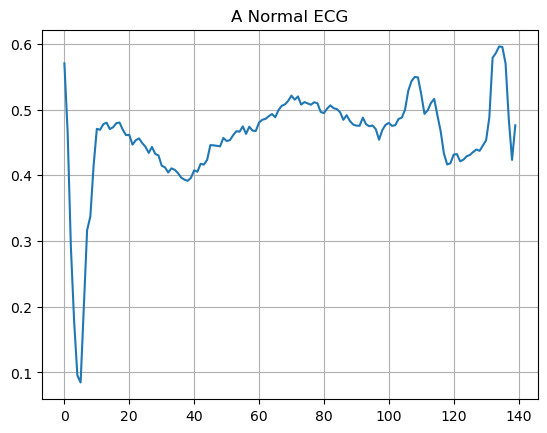

In [16]:
import matplotlib.pyplot as plt 
import numpy as np

plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

Plot an anomalous ECG

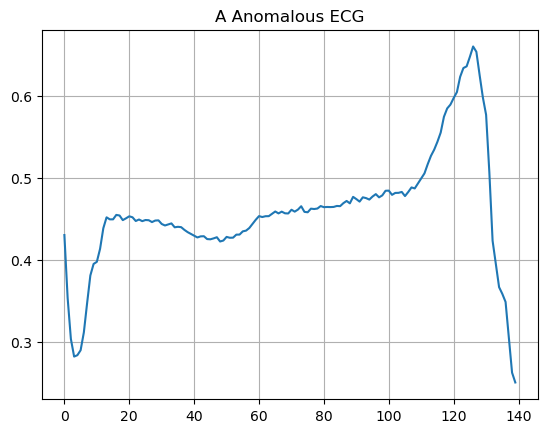

In [11]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('A Anomalous ECG')
plt.show()

Build the model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
class AnomalyDetector(Model):

    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
autoencoder = AnomalyDetector()

In [14]:
autoencoder.compile(optimizer='adam', loss='mae')

In [17]:
history = autoencoder.fit(
    normal_train_data,
    normal_train_data,
    epochs=20,
    batch_size=512,
    validation_data=(test_data, test_data),
    shuffle=True
)

Epoch 1/20


2023-01-23 23:38:15.492723: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7050015040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-23 23:38:15.492884: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce MX350, Compute Capability 6.1
2023-01-23 23:38:15.562366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-23 23:38:16.322149: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-23 23:38:16.419425: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 7s 63ms/step - loss: 0.0577 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0558 - val_loss: 0.0515
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0531 - val_loss: 0.0499
Epoch 4/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0496 - val_loss: 0.0485
Epoch 5/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0459 - val_loss: 0.0463
Epoch 6/20
5/5 [==============================] - 0s 33ms/step - loss: 0.0421 - val_loss: 0.0440
Epoch 7/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0386 - val_loss: 0.0427
Epoch 8/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0355 - val_loss: 0.0410
Epoch 9/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0327 - val_loss: 0.0401
Epoch 10/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0304 - val_loss: 0.0391
Epoch 11/20
5/5 [=======================

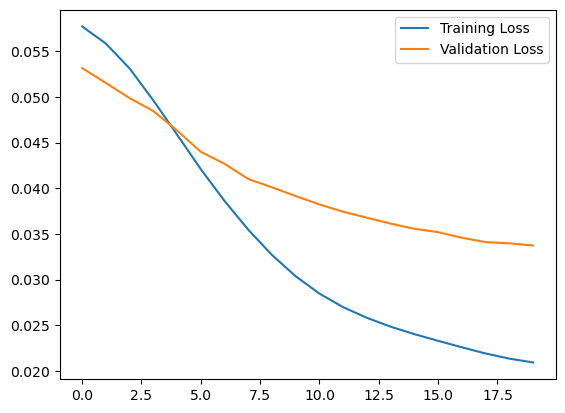

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

Soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let plot a normal ECG from the training set, the reconstruction after it is encoded and decoded by the autoencoder, and the reconstruction error

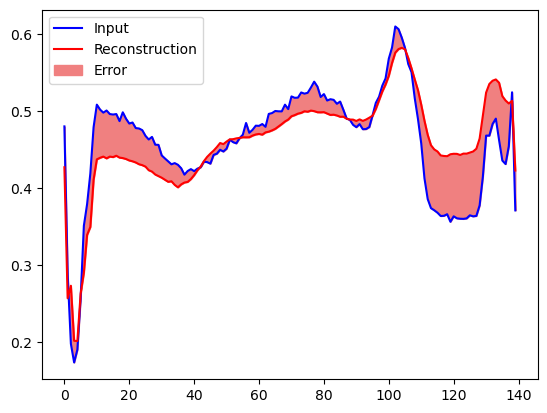

In [19]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(
    np.arange(140), 
    decoded_data[0],
    normal_test_data[0], 
    color='lightcoral'
)
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

create a similar plot, this time for an anomalous test example

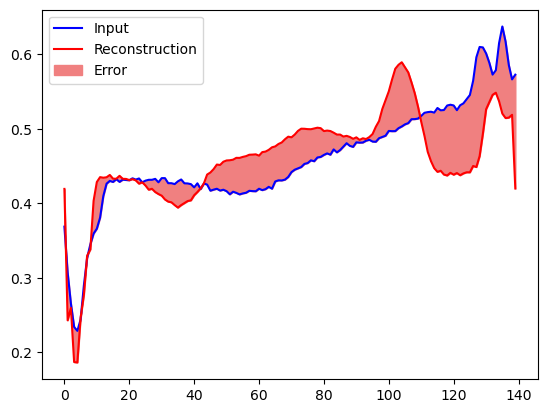

In [20]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], 
                    anomalous_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

# Detect anomalies 

detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. You will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set

74/74 [==============================] - 0s 4ms/step


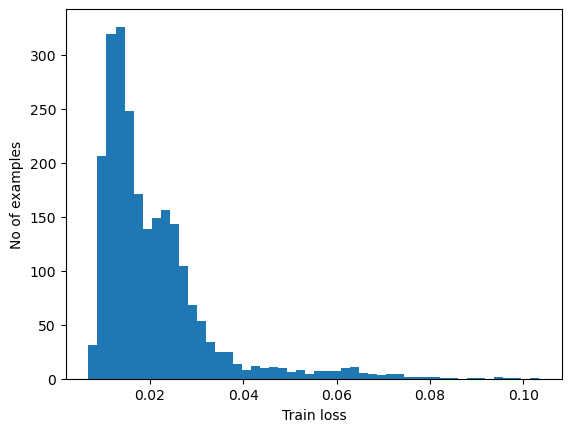

In [21]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Train loss')
plt.ylabel('No of examples')
plt.show()

Choose a threshold value that is one standard deviations above the mean

In [22]:
threshold = np.mean(train_loss) + np.std(train_loss)
print('Threshold: ', threshold)

Threshold:  0.032963578


If the reconstuction error for the anomalous example in the test set, you will notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier

14/14 [==============================] - 0s 5ms/step


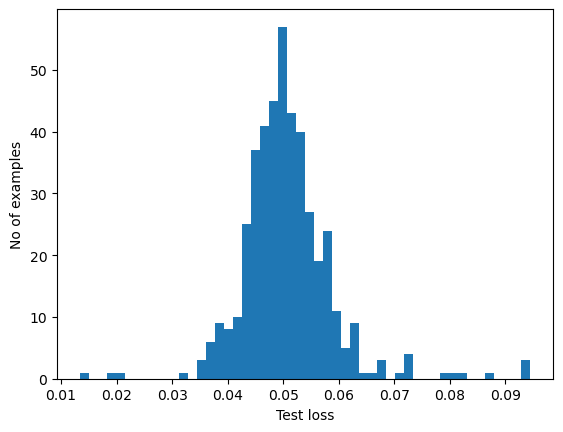

In [23]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel('Test loss')
plt.ylabel('No of examples')
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold

In [24]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score

def print_stats(predictions, labels):
    print('Accuracy: ', accuracy_score(labels, predictions))
    print('Precision: ', precision_score(labels, predictions))
    print('Recall: ', recall_score(labels, predictions))

In [28]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy:  0.945
Precision:  0.9922027290448343
Recall:  0.9089285714285714
